# Create diagrams of impactful boundaries from Bray–Curtis matrices

Take precomputed Bray–Curtis matrices and visualize boundaries between regions, emphasizing those between regions with a heterogeneous composition.

In [1]:
import geopandas as gpd
import pandas as pd
import shapely
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
from libpysal import graph

import preprocess_data

List layers of influential boundaries across Central European history

In [2]:
gpd.list_layers("/data/uscuni-ulce/boundaries_of_change/impact_boundaries.gpkg")

,name,geometry_type
0,1050_political,MultiPolygon
1,1250_political,MultiPolygon
2,1480_political,MultiPolygon
3,1550_religion,MultiPolygon
4,1570_political,MultiPolygon
5,1648_political,MultiPolygon
6,1721_political,MultiPolygon
7,1815_political,MultiPolygon
8,1871_political,Polygon
9,1900_languages,MultiPolygon


In [3]:
boundary_list = list(gpd.list_layers("/data/uscuni-ulce/boundaries_of_change/impact_boundaries.gpkg").name)

In [4]:
level_list = [f"level_{x}" for x in range(1,8)]

Define area of interest (Central Europe)

<Axes: >

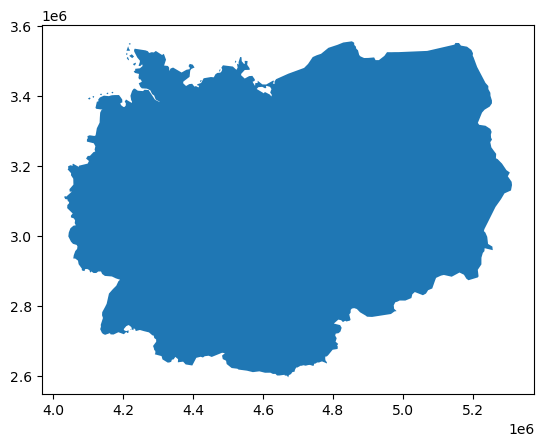

In [5]:
aoi = gpd.read_file("/data/uscuni-ulce/boundaries_of_change/impact_boundaries.gpkg", layer="1994_political")
aoi = aoi.dissolve()
aoi.plot()

Generate boundary diagram for an example layer 

In [6]:
def generate_boundary_diagram(boundary_name, level="level_4", ax=False):
    """Generates a boundary diagram for a given layer."""
    boundary = gpd.read_file("/data/uscuni-ulce/boundaries_of_change/impact_boundaries.gpkg", layer=boundary_name)
    
    #Retrieve level-4 BC matrix for layer of interest
    bray_curtis_matrix = pd.read_parquet(f'/data/uscuni-ulce/boundaries_of_change/bc_matrices/bc_{boundary_name}_{level}.pq')

    #Segment boundaries between adjacent regions
    indices = boundary.sindex.query(boundary.geometry, predicate="intersects")
    left, right = np.unique(np.sort(indices, axis=0), axis=1)

    mask = left == right
    left = left[~mask]
    right = right[~mask]
    geoms = boundary.iloc[left].intersection(boundary.iloc[right], align=False)
    left = boundary.NAME.iloc[left]
    right = boundary.NAME.iloc[right]

    #Retrieve BC dissimilarity values between every two adjacent regions
    border_widths = []
    for l, r in zip(left, right):
        border_widths.append(bray_curtis_matrix.loc[l, r])

    #Recalculate border widths so that higher BC dissimilarity values are emphasized
    border_widths = [(0.1 + 4*(np.exp(2*w) - 1)) for w in border_widths]

    #Create a colormap to emphasize higher BC dissimilarity values between adjacent regions
    norm=plt.Normalize(min(border_widths),max(border_widths))
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["lightgray","black"])

    #Plotting
    if ax:
        for geom, width in zip (geoms, border_widths):
            gpd.GeoSeries([shapely.line_merge(geom)]).plot(ax=ax, linewidth=width, color=cmap(norm(width)))
            ax.set_title(f"{boundary_name}")
    else:
        fig, ax = plt.subplots(figsize=(20,20))
        ax.set_title(boundary_name)
        for geom, width in zip (geoms, border_widths):
            gpd.GeoSeries([shapely.line_merge(geom)]).plot(ax=ax, linewidth=width, color=cmap(norm(width)))

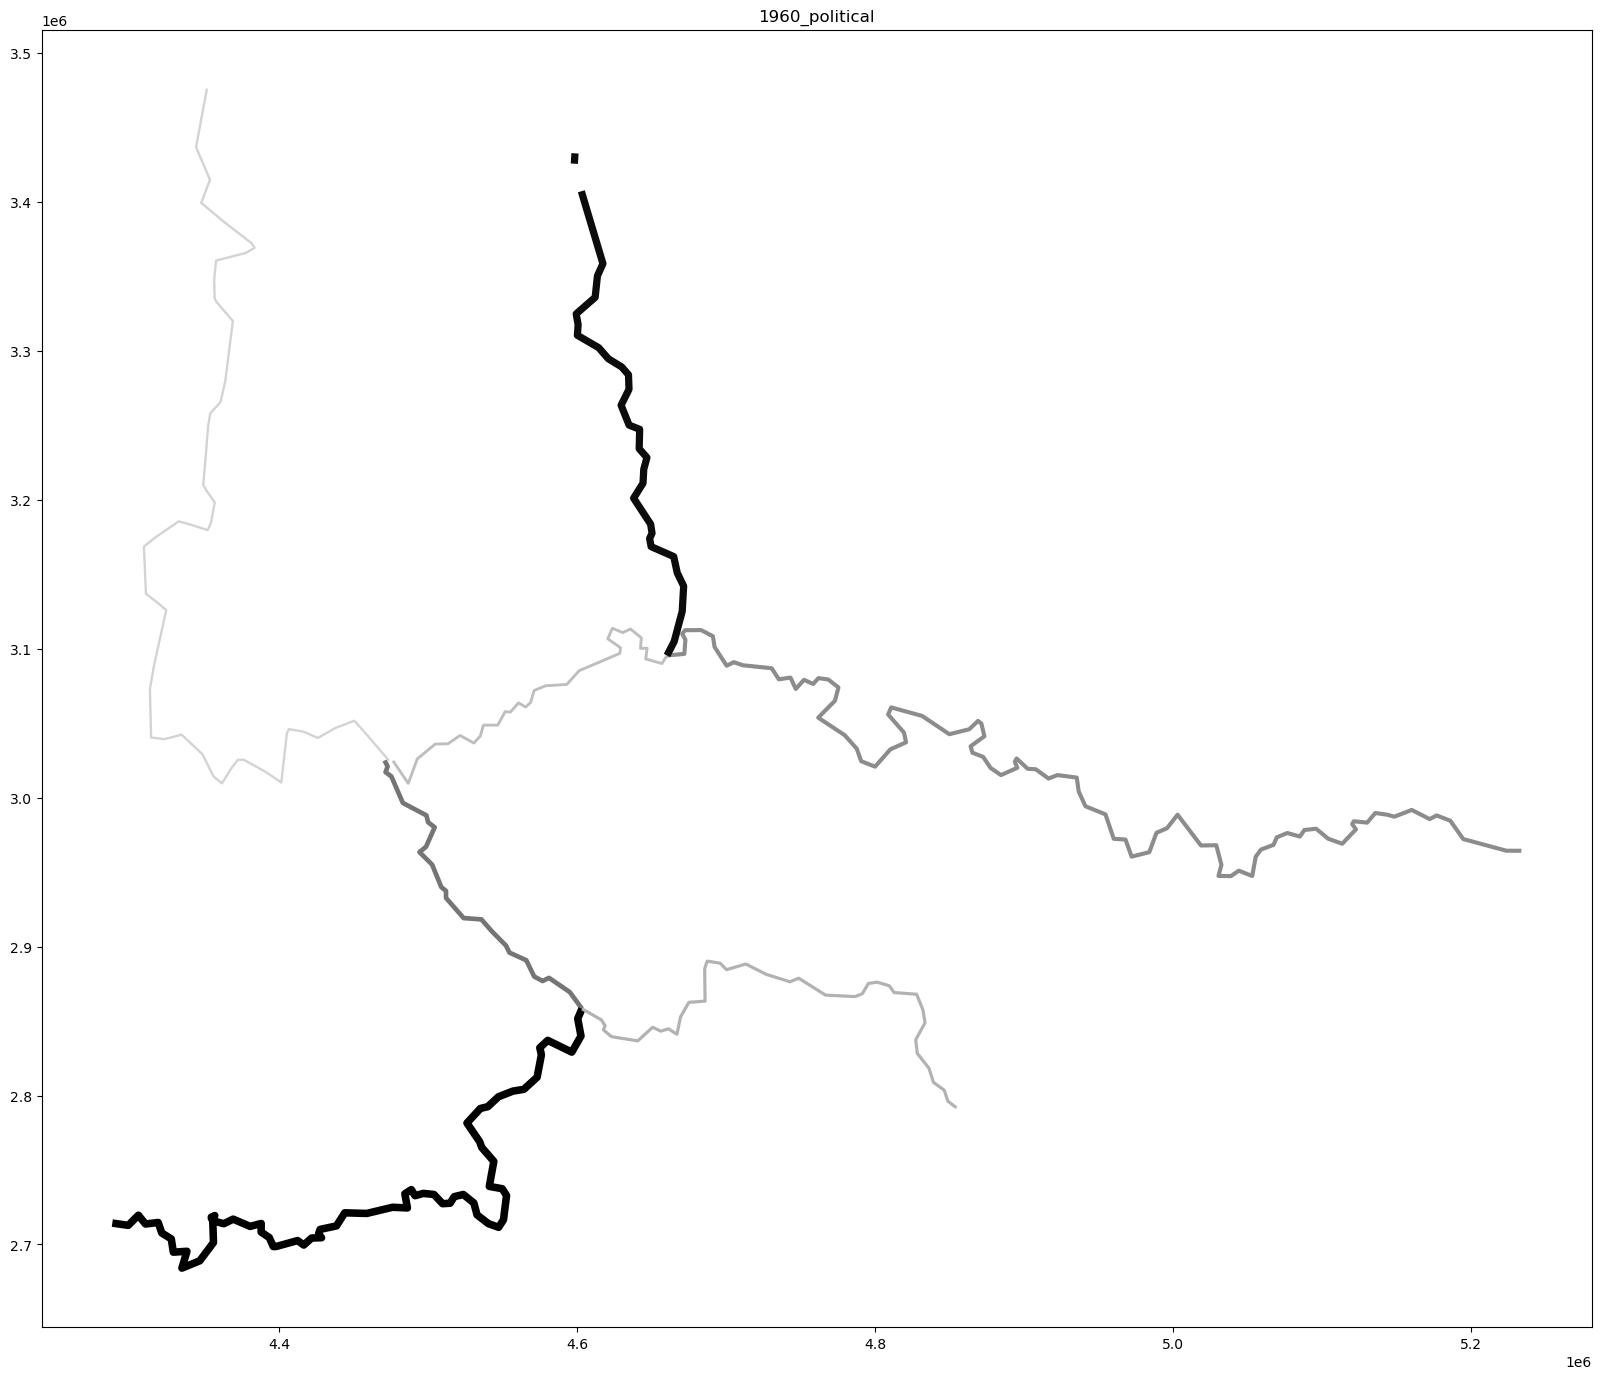

In [7]:
generate_boundary_diagram("1960_political")

Generate such boundary diagram for each layer

In [8]:
def generate_boundary_diagrams(boundary_lst, level, show_aoi=False):
    """Generates boundary diagrams for each layer in boundary_lst baseon on specified level."""
    fig, axs = plt.subplots(ncols=5, nrows=3, figsize=(20,10), sharex=True, sharey=True)
    axs = axs.flatten()
    fig.suptitle(level)
    for i, boundary in enumerate(boundary_list):
        if show_aoi:
            aoi.plot(ax=axs[i], color='whitesmoke')
        generate_boundary_diagram(boundary, level, ax=axs[i])

    plt.tight_layout()

    for ax in axs:
        ax.set_axis_off()

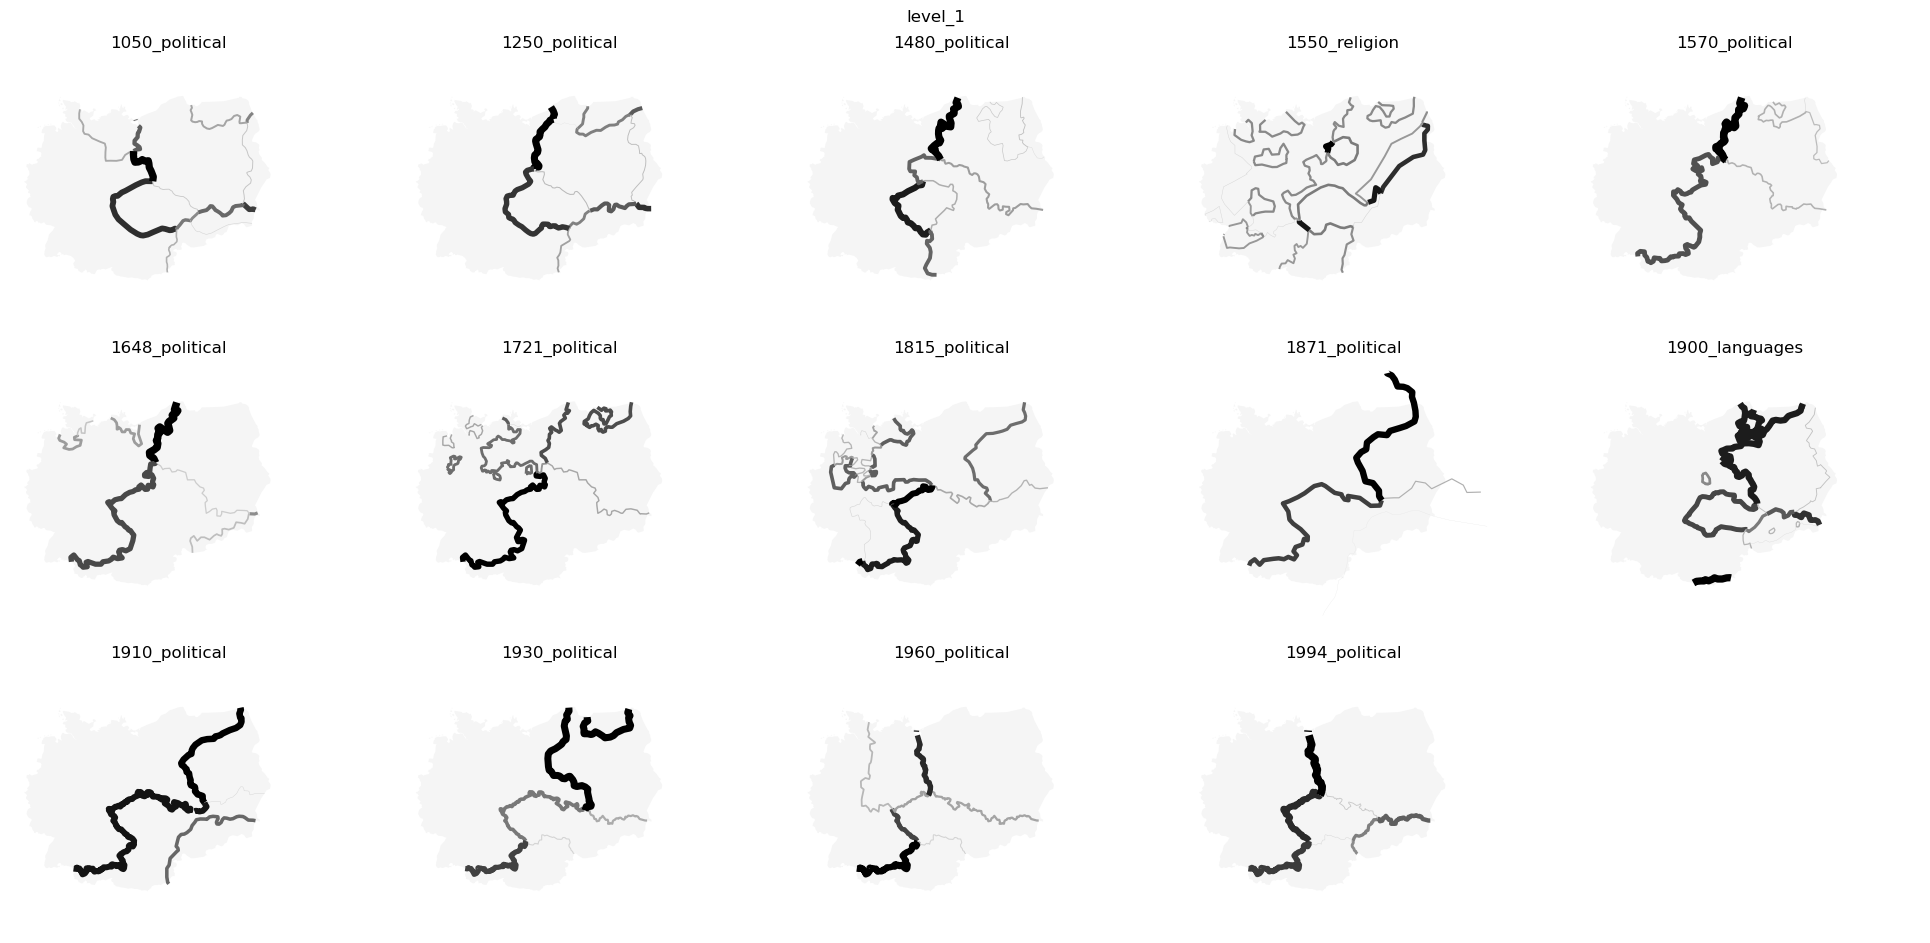

In [9]:
generate_boundary_diagrams(boundary_list, "level_1", show_aoi=True)

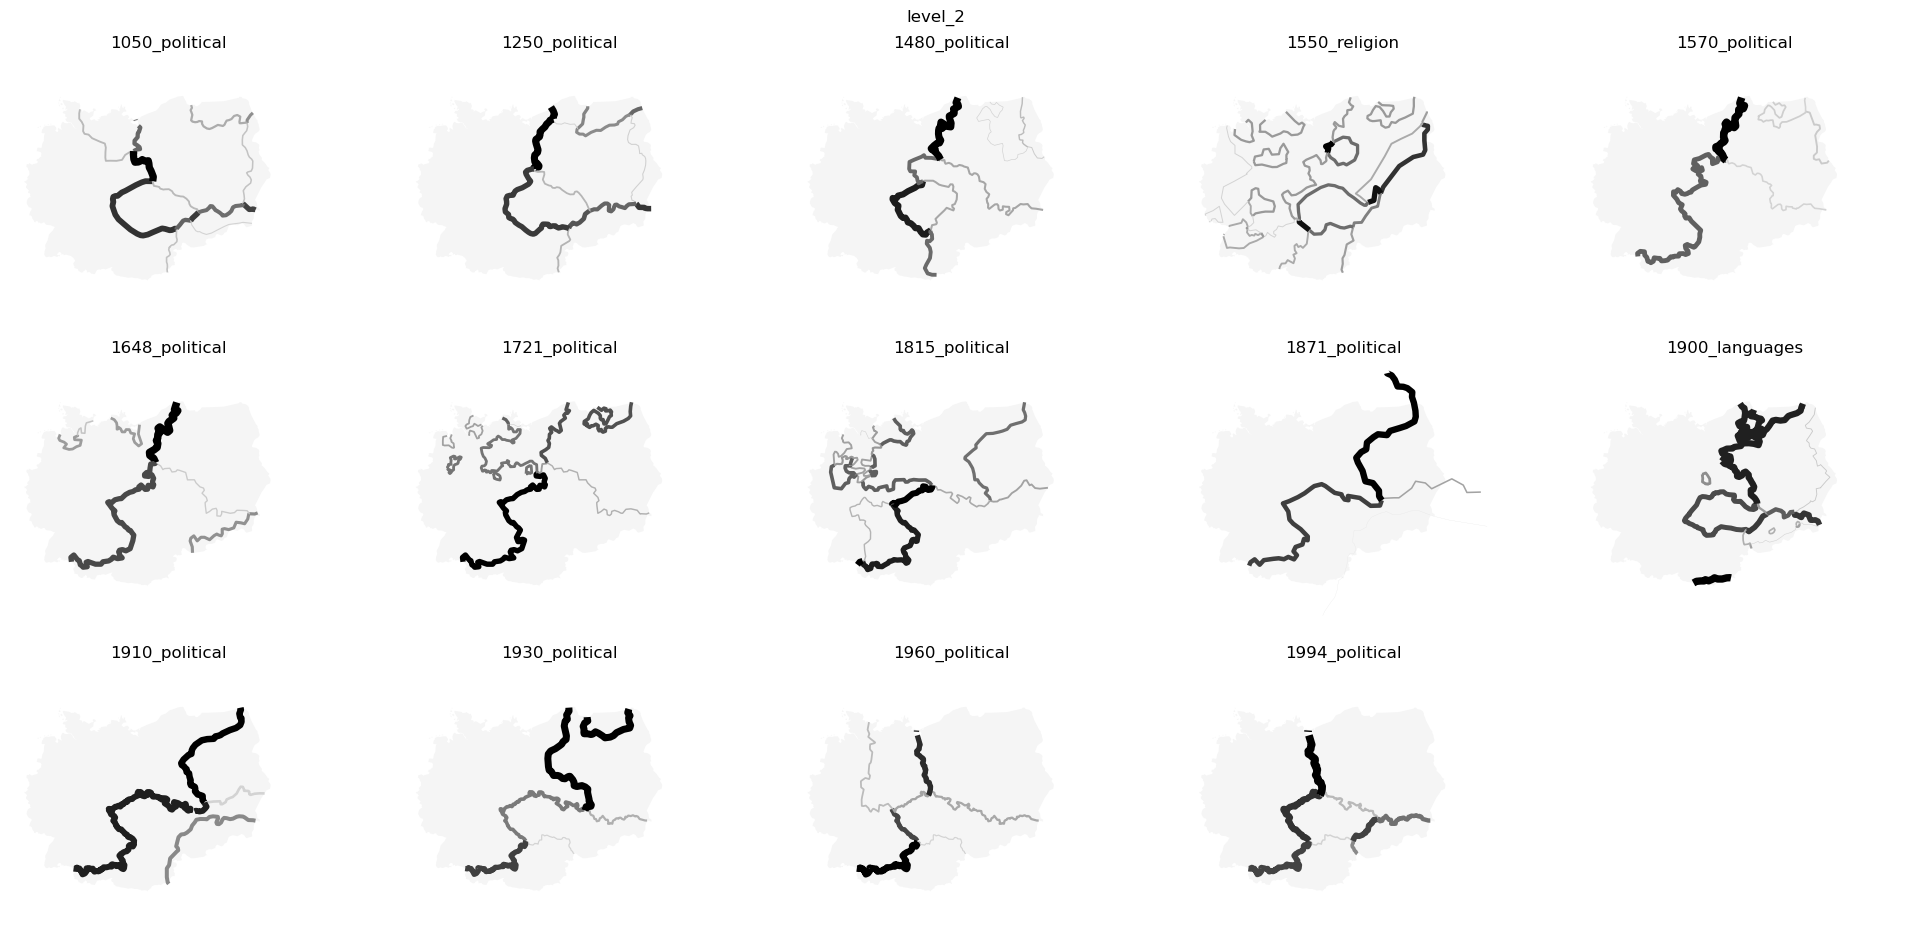

In [10]:
generate_boundary_diagrams(boundary_list, "level_2", show_aoi=True)

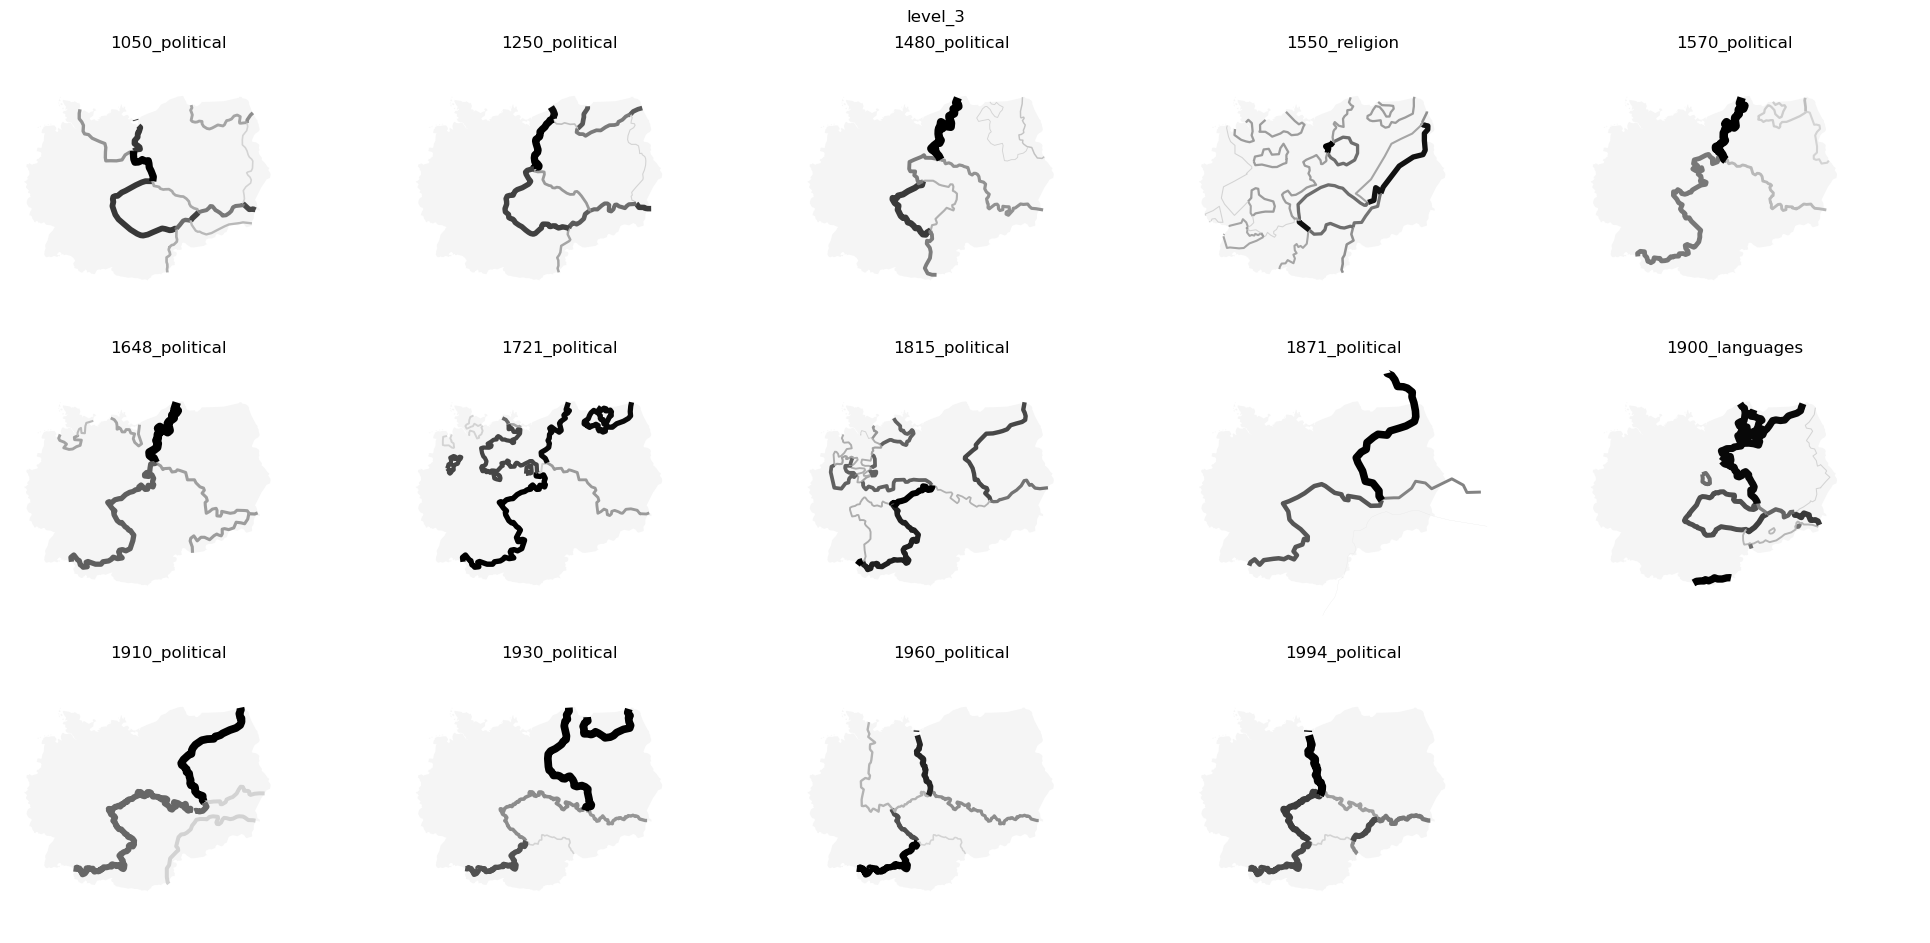

In [11]:
generate_boundary_diagrams(boundary_list, "level_3", show_aoi=True)

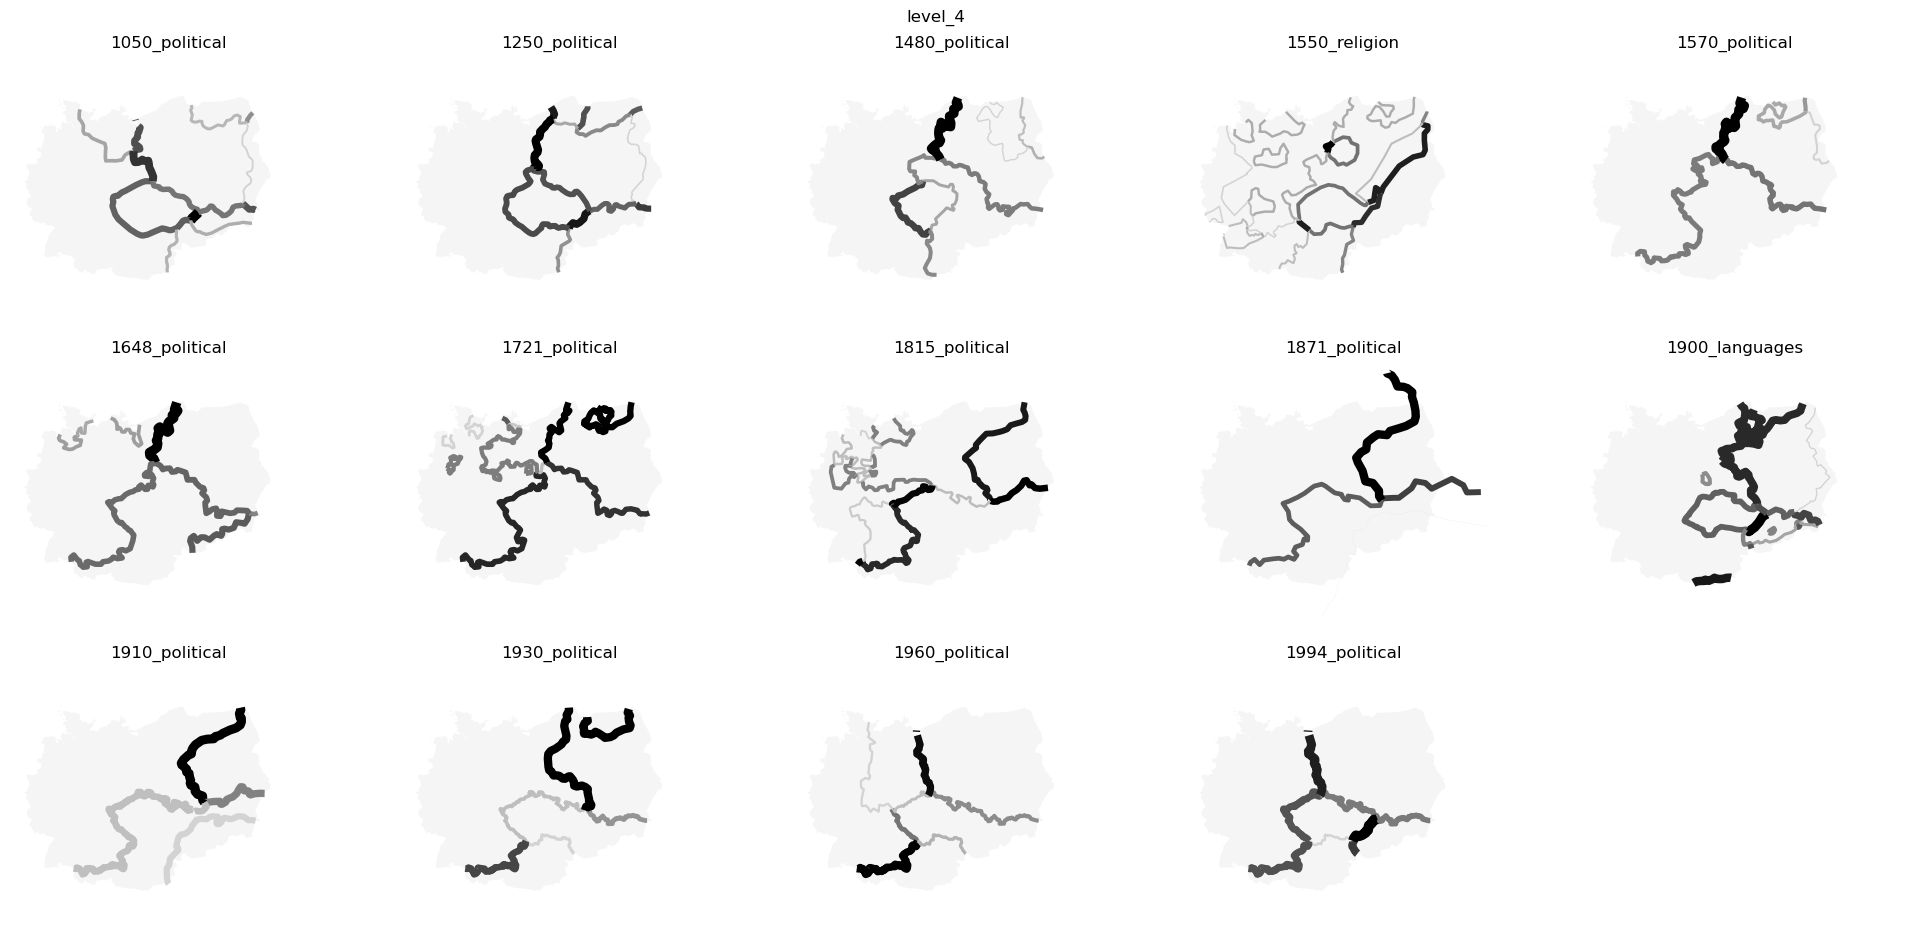

In [12]:
generate_boundary_diagrams(boundary_list, "level_4", show_aoi=True)

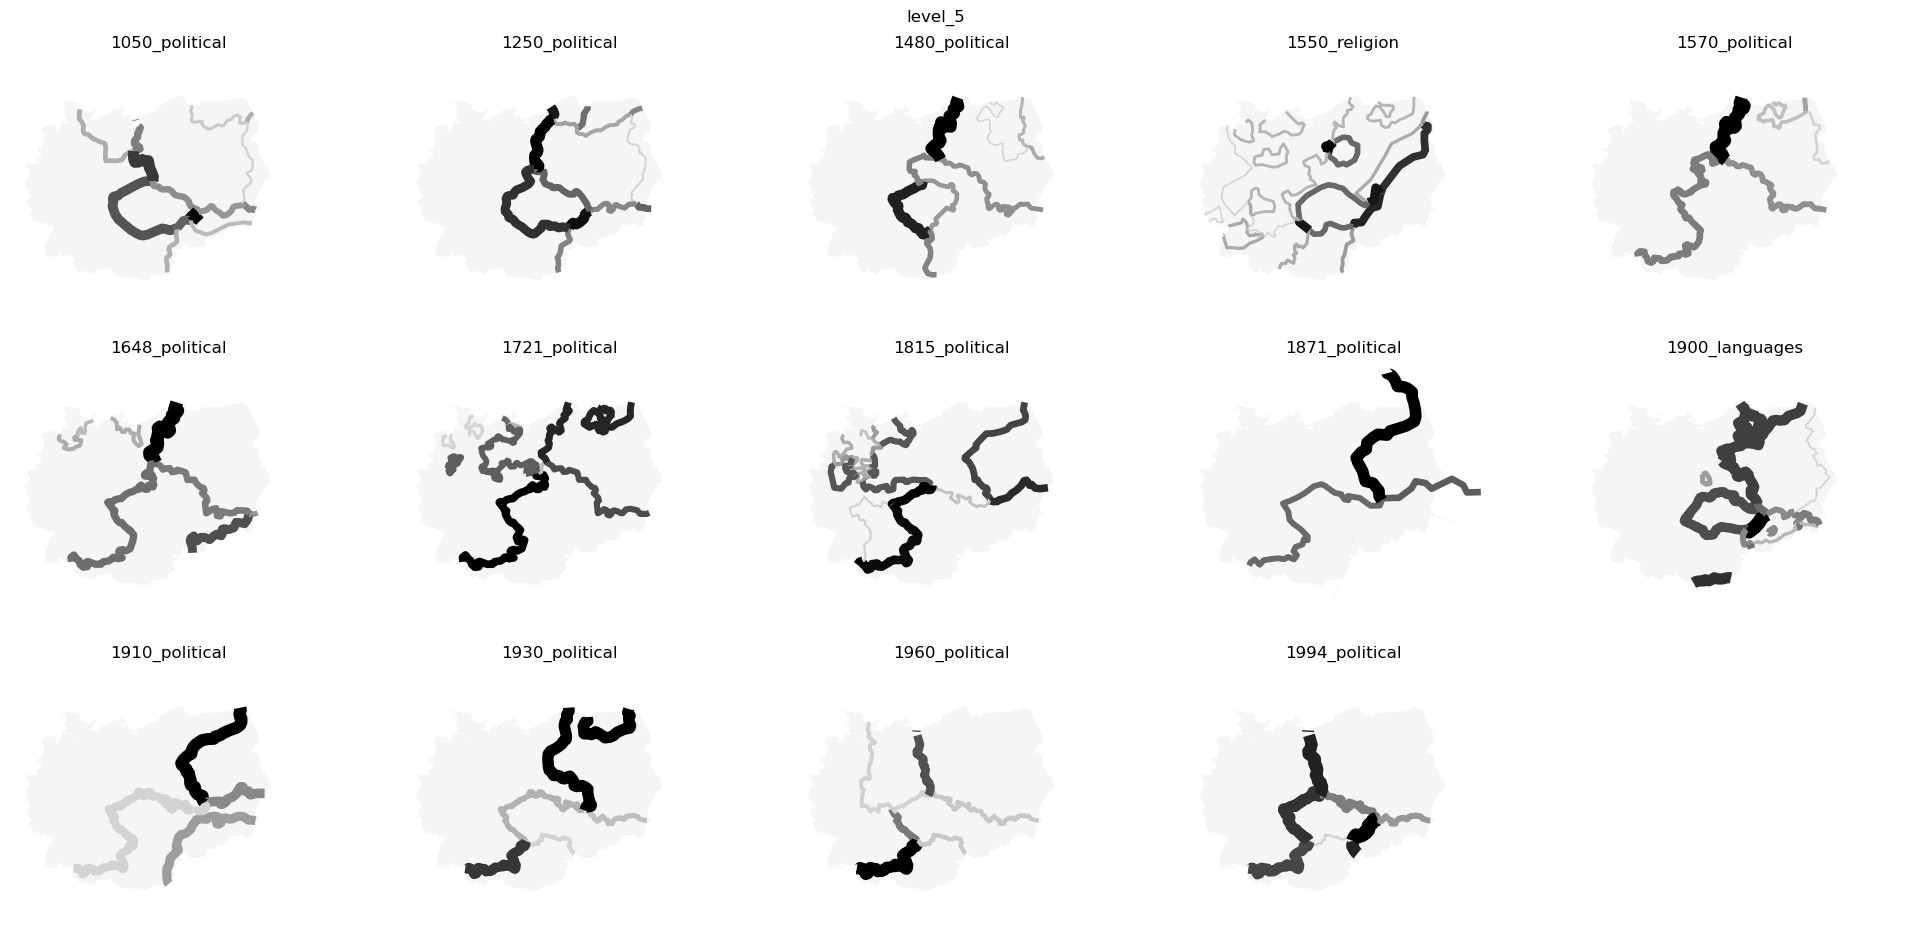

In [13]:
generate_boundary_diagrams(boundary_list, "level_5", show_aoi=True)

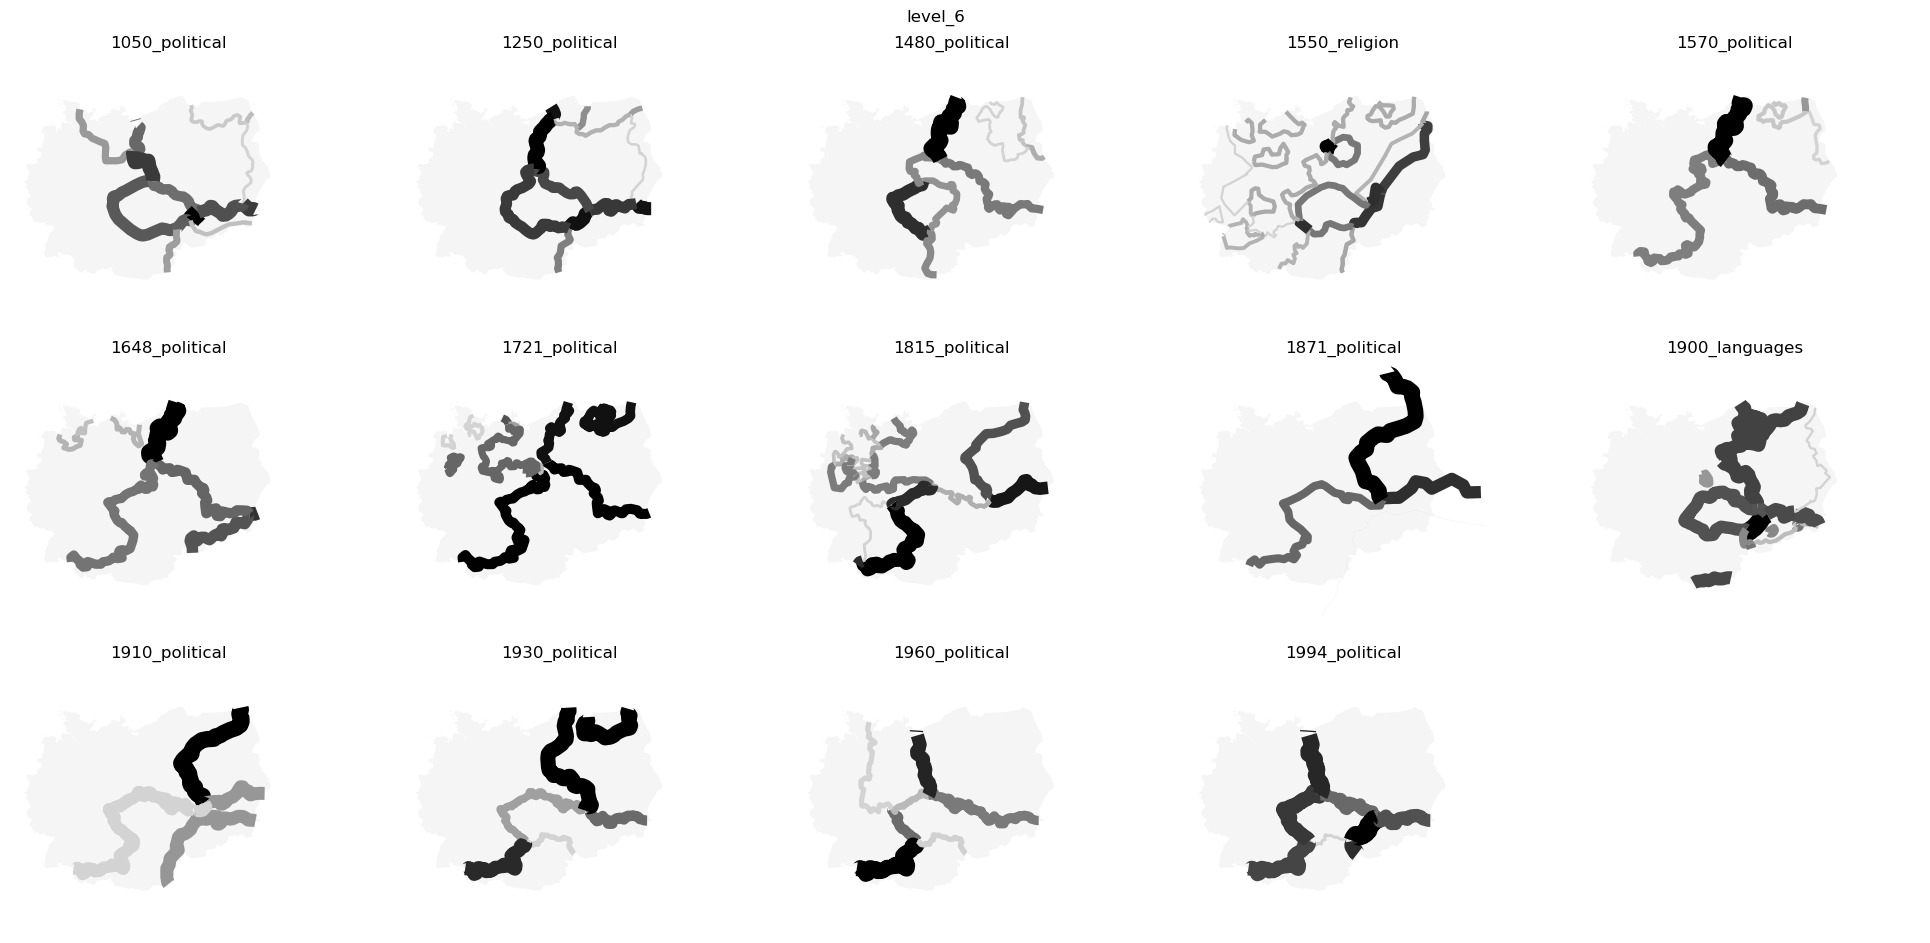

In [14]:
generate_boundary_diagrams(boundary_list, "level_6", show_aoi=True)

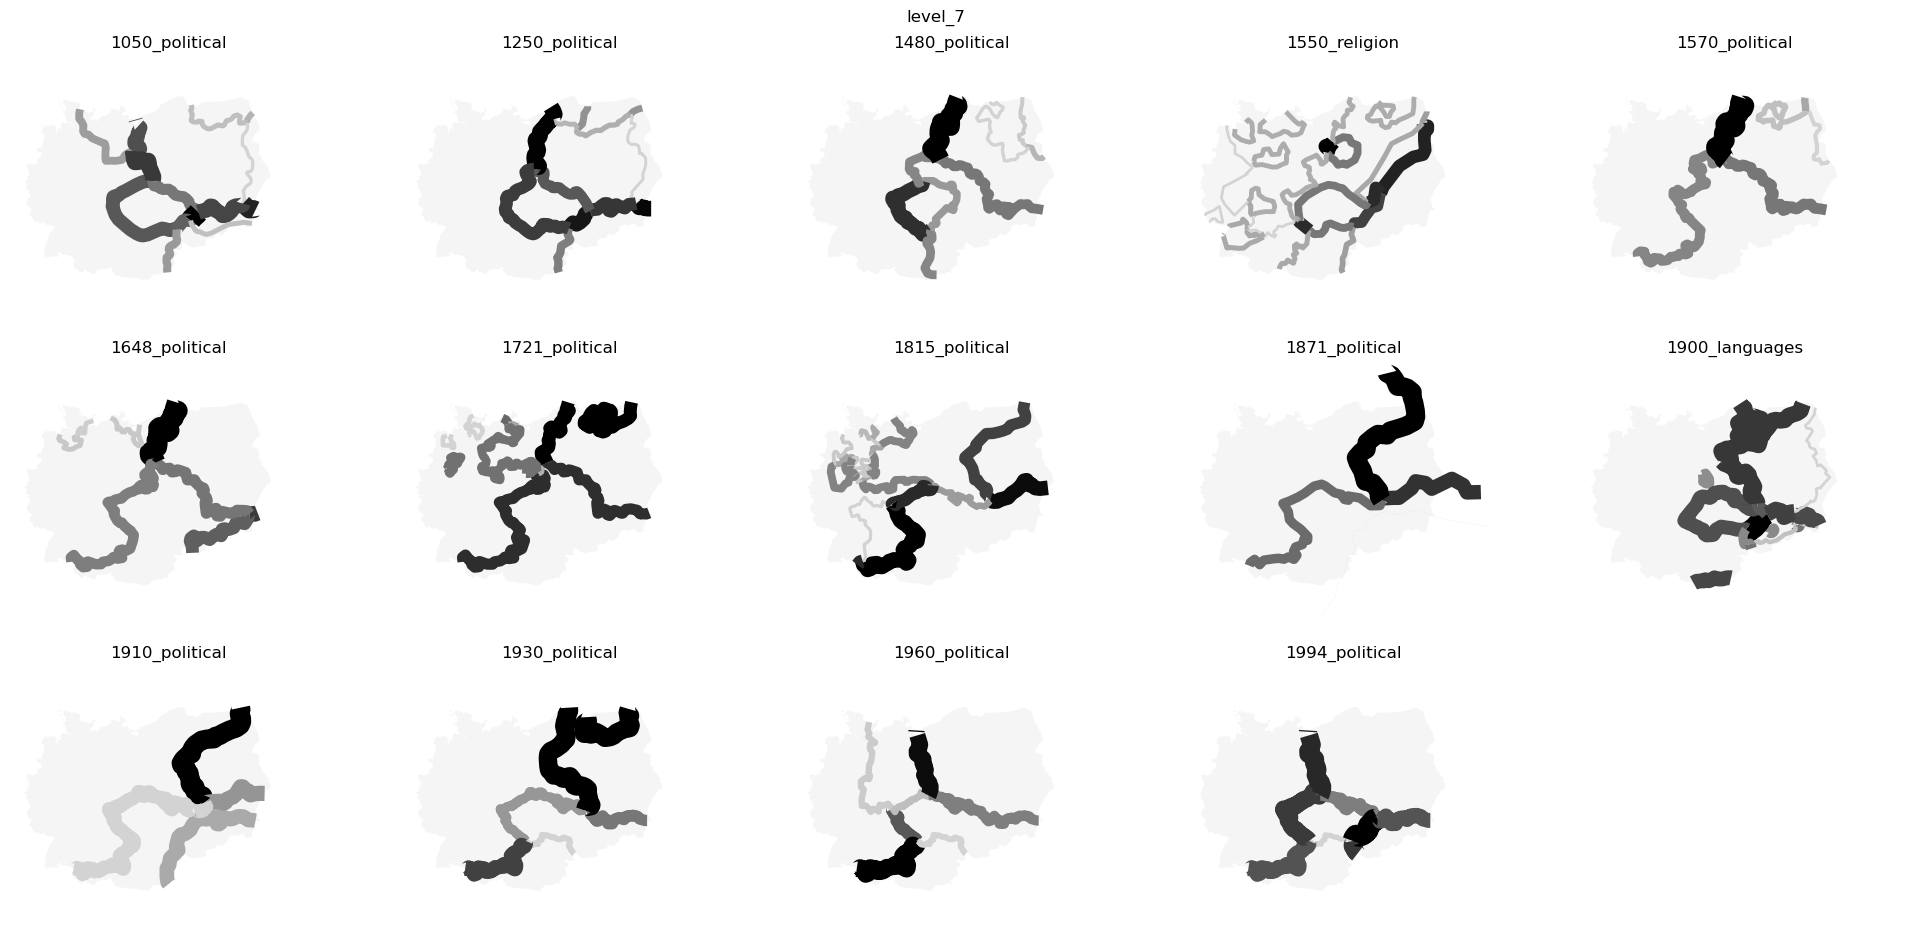

In [15]:
generate_boundary_diagrams(boundary_list, "level_7", show_aoi=True)